## Exercise 1:  Wide and Deep Networks

- Try changing your assumptions about which features should be considered by the "non-linear" (deep) part of the network.  Can you get any improvements?
- Try using a different activation function in your wide and deep network. Do you get any improvements here?

Epoch 1/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 2.3832 - loss: 5.6873 - val_RootMeanSquaredError: 2.0303 - val_loss: 4.1215
Epoch 2/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - RootMeanSquaredError: 1.9192 - loss: 3.6914 - val_RootMeanSquaredError: 1.8225 - val_loss: 3.3206
Epoch 3/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.4420 - loss: 2.0843 - val_RootMeanSquaredError: 1.6149 - val_loss: 2.6072
Epoch 4/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - RootMeanSquaredError: 1.1853 - loss: 1.4060 - val_RootMeanSquaredError: 1.3304 - val_loss: 1.7694
Epoch 5/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.1003 - loss: 1.2111 - val_RootMeanSquaredError: 1.1151 - val_loss: 1.2432
Epoch 6/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.0475 - loss: 1.0977 - val_RootMeanSquaredError: 1.0159 - val_loss: 1.0318
Epoch 7/40
363/363 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - RootMeanSquaredError: 1.0025 - los

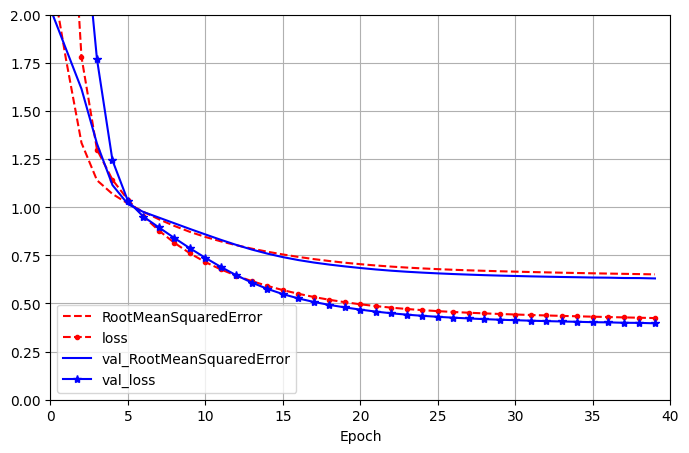

In [21]:
import tensorflow as tf
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LeakyReLU

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)
# Reserve an item for prediction
X_new = X_test[:3]

tf.keras.backend.clear_session()
tf.random.set_seed(42)

input_wide = tf.keras.layers.Input(shape=[6]) # features 0 to 4 
input_deep = tf.keras.layers.Input(shape=[5]) # features 2 to 7 
norm_layer_wide = tf.keras.layers.Normalization() 
norm_layer_deep = tf.keras.layers.Normalization()
norm_wide = norm_layer_wide(input_wide)
norm_deep = norm_layer_deep(input_deep)

# Note, the following is just a shorthand where we construct and then attach the network all in one go
hidden1 = tf.keras.layers.Dense(30, activation=LeakyReLU())(norm_deep)
hidden2 = tf.keras.layers.Dense(30, activation=LeakyReLU())(hidden1)
concat = tf.keras.layers.concatenate([norm_wide, hidden2])
output = tf.keras.layers.Dense(1)(concat)
model = tf.keras.Model(inputs=[input_wide, input_deep], outputs=[output])


optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mse", optimizer=optimizer, metrics=["RootMeanSquaredError"])

# Note the offsets are used here to split up the features according to our input layer
X_train_wide, X_train_deep = X_train[:, :6], X_train[:, 3:] 
X_valid_wide, X_valid_deep = X_valid[:, :6], X_valid[:, 3:] 
X_test_wide, X_test_deep = X_test[:, :6], X_test[:, 3:] 
X_new_wide, X_new_deep = X_test_wide[:3], X_test_deep[:3]


norm_layer_wide.adapt(X_train_wide) 
norm_layer_deep.adapt(X_train_deep)

history = model.fit((X_train_wide, X_train_deep), y_train, epochs=40, validation_data=((X_valid_wide, X_valid_deep), y_valid)) 
mse_test = model.evaluate((X_test_wide, X_test_deep), y_test)
y_pred = model.predict((X_new_wide, X_new_deep))

import matplotlib.pyplot as plt
import pandas as pd

pd.DataFrame(history.history).plot(
    figsize=(8, 5), xlim=[0, 40], ylim=[0, 2], grid=True, xlabel="Epoch",
    style=["r--", "r--.", "b-", "b-*"])
plt.legend(loc="lower left")  # extra code
plt.show()



## Exercise 2: Modifying the Wide and Deep Network

Modify the constructor of the wide and deep network to take parameters that govern the number of hidden layers and their width.  Now try running the new network with different properties for your hidden layers.  Can you improve your performance?

## Exercise 3: Comparing SELU and ReLU

Let's examine the performance of SELU and ReLU in the context of a deep network with 100 layers.  I've set up the example below to use SELU and Lecun Normalization.  Examine the performance, and then contrast using ReLU and He normalization.

In [22]:
import tensorflow as tf
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))

# 100 hidden layers
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Get the data and train the network:

In [23]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]

# Remember to scale the inputs!
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]


pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


2024-04-02 16:09:21.337674: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 172480000 exceeds 10% of free system memory.


1714/1719 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3882 - loss: 1.5854

2024-04-02 16:09:37.158884: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15680000 exceeds 10% of free system memory.


1719/1719 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - accuracy: 0.3885 - loss: 1.5846 - val_accuracy: 0.6534 - val_loss: 0.9262
Epoch 2/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.6244 - loss: 0.9867 - val_accuracy: 0.6490 - val_loss: 0.8955
Epoch 3/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.6536 - loss: 0.9024 - val_accuracy: 0.6134 - val_loss: 1.0179
Epoch 4/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - accuracy: 0.7289 - loss: 0.7409 - val_accuracy: 0.7548 - val_loss: 0.6526
Epoch 5/5
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.7500 - loss: 0.6818 - val_accuracy: 0.7162 - val_loss: 0.8293
